# Analyze FIT file: optical HR sensor vs. chest strap

Compare built-in heart rate sensor / paired sensor (field "heart_rate") with external / unpaired ANT+ sensor (field "ANT HR").

Use case: check accuracy of built-in heart rate sensor vs. allegedly more precise reference.

Prerequisites:
- Garmin watch with optical HRM
- ANT+ HRM installed (https://apps.garmin.com/apps/7c83d402-4b68-4f0a-b167-7139788a19b3)
- Activity configured with ANT+ HRM data field in a data screen (https://flocsy.eu/projects/garmin/ANT+HRM/FAQ.md)
- Activity recorded with optical HRM and ANT+ HRM
- Activity FIT file converted to CSV (https://developer.garmin.com/fit/fitcsvtool/windows/)

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


FIT_EPOCH_S = 631065600 # Garmin FIT SDK /py/garmin_fit_sdk/util.py

## Load and preprocess data

In [155]:
data = pd.read_csv('14036113189_ACTIVITY.csv')

C:\Users\ag\AppData\Local\Temp/ipykernel_17048/2051559470.py:1: DtypeWarning: Columns (7,16,26,29,35,36,38,39,41,42,43,44,45,47,48,50,51,53,54,56,57,59,60,62,63,65,66,68,69,71,72,74,75,77,78,80,81,84,87,88,90,92,93,94,95,96,98,99,101,102,104,105,108,111,114,117,118,120,123,126,128,129,131,132,134,135,138,141,142,144,147,150,153,156,159,162,165,168,171,174,177,180,183,186,189,192,195,198,201,204,207,210,213,216,219,222,225,228,231,234,237,240,243,246,249,252,255,258,261,264,267,270,273,276,279,282,285,288,291,294,297,300,303,306,309,312,315,318,321,324,327,330,333,336,339,342,345,348,351,354,357) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('14680176268_ACTIVITY.csv')


In [156]:
# Clean data

data = data[(data['Type']=='Data') & (data['Message']=='record')] \
    .drop(['Type', 'Local Number', 'Message'], axis='columns')

data = data.dropna(axis='columns', how='all')

del_fields = [index for (index, item) in enumerate(data.columns) if item.startswith('Units')]

data = data.drop(data.columns[del_fields], axis='columns')


In [157]:
# Extract only needed fields

field_cols = [index for (index, item) in enumerate(data.columns) if item.startswith('Field')]

field_names = data[data.columns[field_cols]].mode().iloc[0]

needed_fields = ['timestamp', 'heart_rate', 'ANT_HR']

rename_dict = {
    field_names[field_names == name].index[0].replace('Field', 'Value'): field_names[field_names == name][0]
    for name in needed_fields
    }

data = data.rename(columns=rename_dict)[needed_fields]

data['heart_rate'] = data['heart_rate'].astype(float)
data['ANT_HR'] = data['ANT_HR'].astype(float)
data['timestamp'] = (data['timestamp'].astype(int) + FIT_EPOCH_S).apply(pd.Timestamp.utcfromtimestamp)
data = data.set_index('timestamp')


C:\Users\ag\AppData\Local\Temp/ipykernel_17048/1914189180.py:18: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  data['timestamp'] = (data['timestamp'].astype(int) + FIT_EPOCH_S).apply(pd.Timestamp.utcfromtimestamp)


In [158]:
# Final clean and extra field

print(data.info())

data = data.dropna(axis='rows', how='any')

data['diff'] = (data['heart_rate'] - data['ANT_HR'])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6176 entries, 2024-04-01 08:34:20 to 2024-04-01 10:18:04
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   heart_rate  6176 non-null   float64
 1   ANT_HR      6150 non-null   float64
dtypes: float64(2)
memory usage: 144.8 KB
None


In [159]:
data.head()

,heart_rate,ANT_HR,diff
timestamp,,,
2024-04-01 08:34:21,83.0,114.0,-31.0
2024-04-01 08:34:23,84.0,106.0,-22.0
2024-04-01 08:34:26,85.0,112.0,-27.0
2024-04-01 08:34:27,85.0,112.0,-27.0
2024-04-01 08:34:28,85.0,112.0,-27.0


In [160]:
def plot_linechart(hr1: pd.Series, hr2: pd.Series, diff: pd.Series):
    '''Plot sensors data and difference'''
    f, ax = plt.subplots(2, 1, squeeze=True, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    f.set_size_inches(20, 7)

    sns.lineplot(data=hr1, color='blue', label=hr1.name, ax = ax[0])
    sns.lineplot(data=hr2, color='red', label=hr2.name, ax = ax[0])
    ax[0].set_ylabel('bpm')
    ax[0].legend()
    sns.lineplot(data=diff.rename('Error, bpm'), ax=ax[1])
    ax[1].axhline(0, color='r', linestyle='--')
    line = ax[1].get_lines()
    plt.fill_between(line[0].get_xdata(), line[0].get_ydata(), [0]*len(diff), color='blue', alpha=.1)    


In [161]:
def plot_distribution(hr1: pd.Series, hr2: pd.Series, diff: pd.Series):
    '''Plot distribution of sensors data difference'''
    f, ax = plt.subplots(1, 3, squeeze=True)
    f.set_size_inches(20, 5)

    sns.scatterplot(data=pd.concat([hr1, hr2], axis='columns'), x=hr1.name, y=hr2.name, ax=ax[0])
    hr_min = hr1.min()
    hr_max = hr1.max()
    sns.lineplot(data=pd.DataFrame({hr1.name: [hr_min, hr_max], hr2.name: [hr_min, hr_max]}),
                 x=hr1.name, y=hr2.name, color='r', linestyle='--', ax=ax[0])

    sns.histplot(data=diff.rename('Error, bpm'), ax=ax[1])
    ax[1].axvline(diff.mean(), color='r', linestyle='--', label=f'ME = {diff.mean():.2f}')
    ax[1].legend()

    sns.histplot(data=(diff / hr1 * 100).rename('Percentage error'), ax=ax[2])
    ax[2].axvline((diff / hr1 * 100).mean(), color='r', linestyle='--', label=f'MPE = {(diff / hr1 * 100).mean():.2f}')
    ax[2].legend()


In [162]:
def crosscorrelation_chart(hr1, hr2, lag=(-10, 10), ax=None) -> int:
    '''Plot correlation between sensors data at various delays, return best delay'''
    lags = list(range(*lag))
    correlations = [hr1.corr(hr2.shift(-lag)) for lag in lags]
    if ax is None:
        f, ax = plt.subplots()
    ax.set(xlabel='Delay, s', ylabel='Pearson r')
    maxcorr = lags[np.argmax(correlations)]
    ax.plot(lags, correlations, label=f'Peak @ {maxcorr} seconds')
    ax.axvline(maxcorr, color='r', linestyle='--')
    plt.legend()
    return maxcorr


In [163]:
def error_stats(hr1: pd.Series, hr2: pd.Series, diff: pd.Series):
    print(f'Duration: {hr1.index[-1] - hr1.index[0]}')
    print(f'Mean {hr1.name}: {hr1.mean():.2f}')
    print(f'Mean {hr2.name}: {hr2.mean():.2f}')
    print(f"MAPE = {(diff.abs() / hr1).mean() * 100:.2f}%")
    print(f"MAE = {diff.abs().mean():.2f} bpm")
    print(f"RMSE = {(diff**2).mean()**(1/2):.2f} bpm")
    print(f"Correlation = {hr1.corr(hr2, method='pearson'):.3f}")

## Visualize data

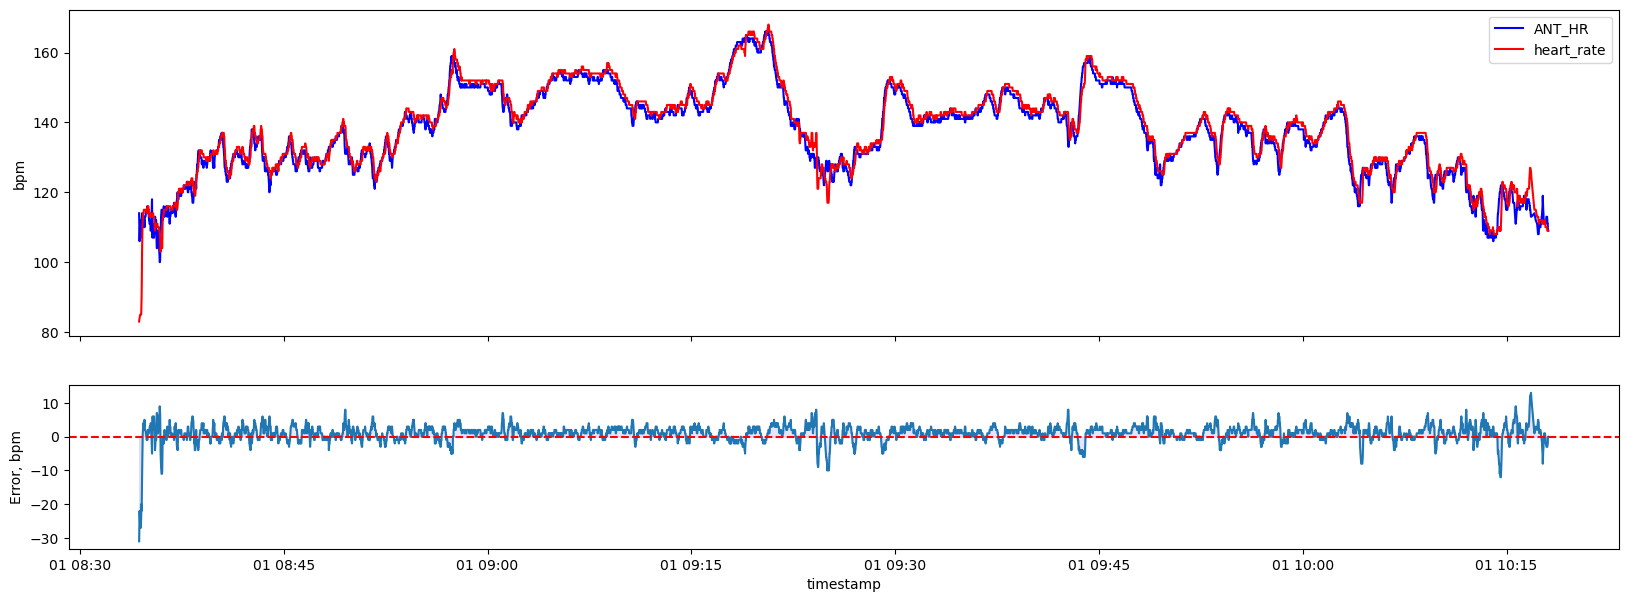

In [164]:
plot_linechart(data['ANT_HR'], data['heart_rate'], data['diff'])

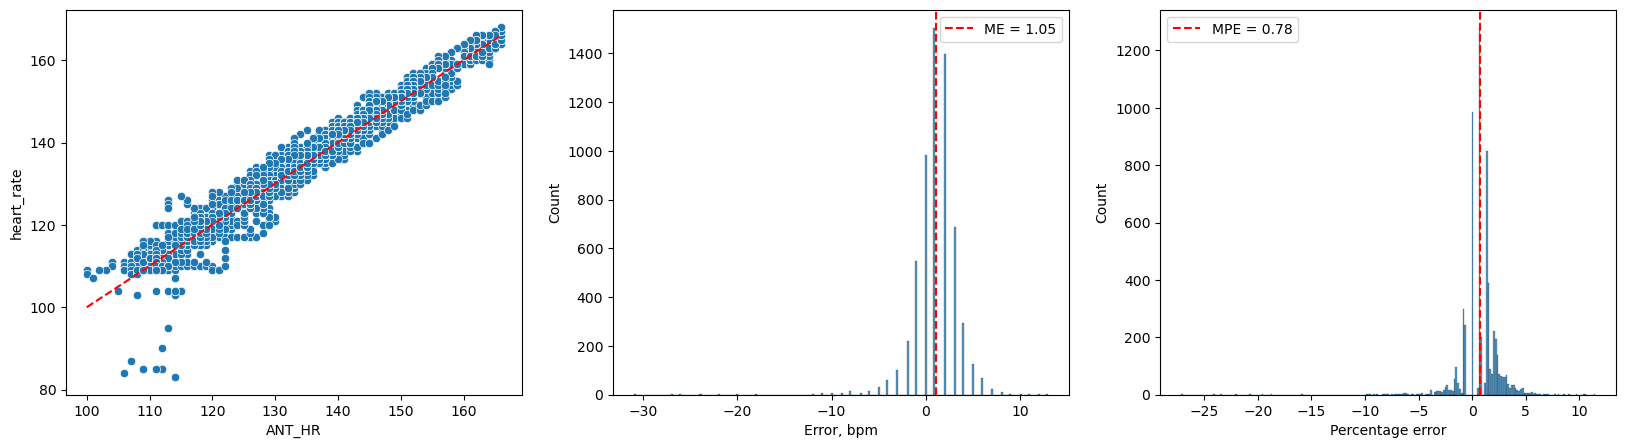

In [165]:
plot_distribution(data['ANT_HR'], data['heart_rate'], data['diff'])

## Estimate if built-in sensor is "delayed"

Sometimes optical HRM data appears visually lagging behind chest strap

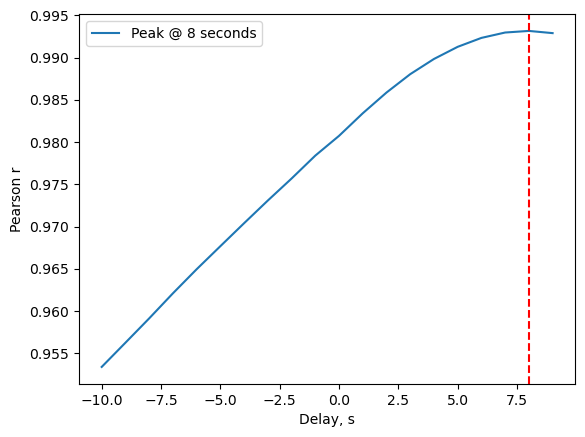

In [166]:
delay = crosscorrelation_chart(data['ANT_HR'], data['heart_rate'])

## Repeat analysis with built-in sensor data delay-adjusted

In [167]:
data['heart_rate_shifted'] = data['heart_rate'].shift(-delay)
data['diff_shifted'] = (data['heart_rate_shifted'] - data['ANT_HR'])
data_shifted = data.dropna()

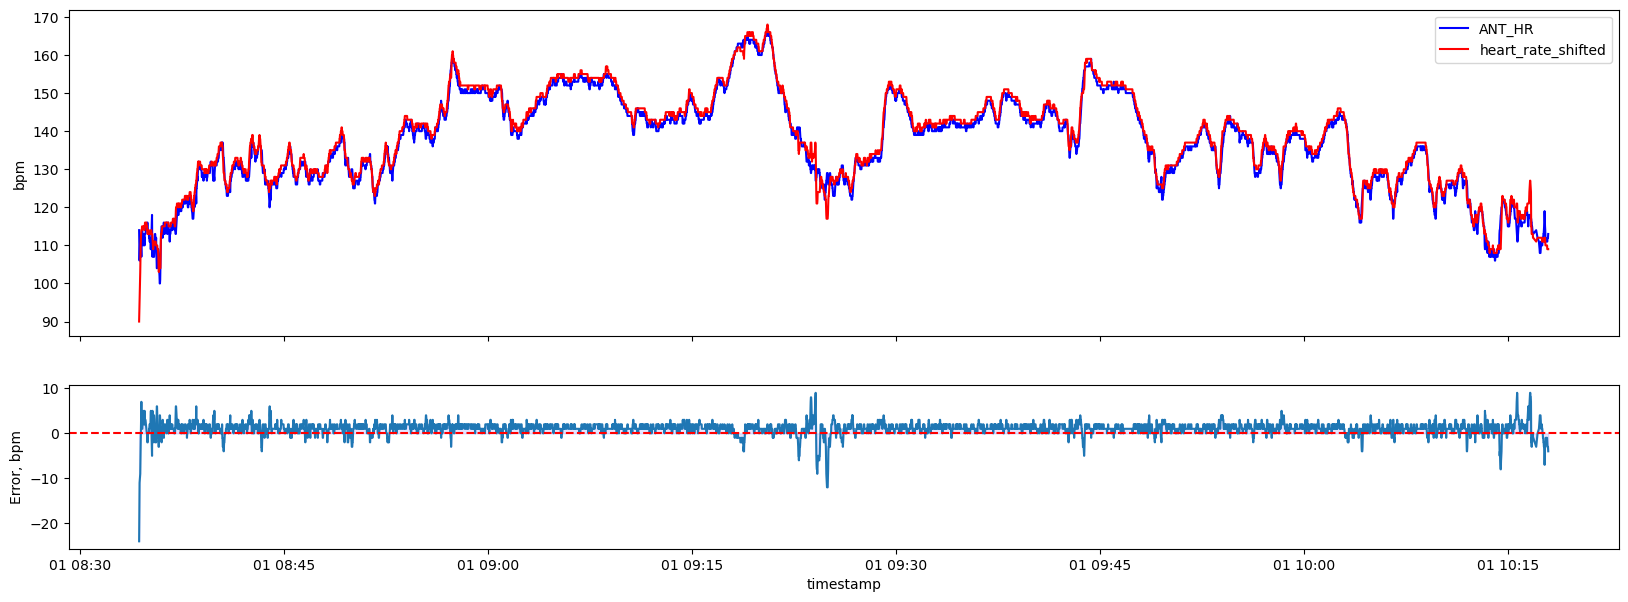

In [168]:
plot_linechart(data_shifted['ANT_HR'], data_shifted['heart_rate_shifted'], data_shifted['diff_shifted'])

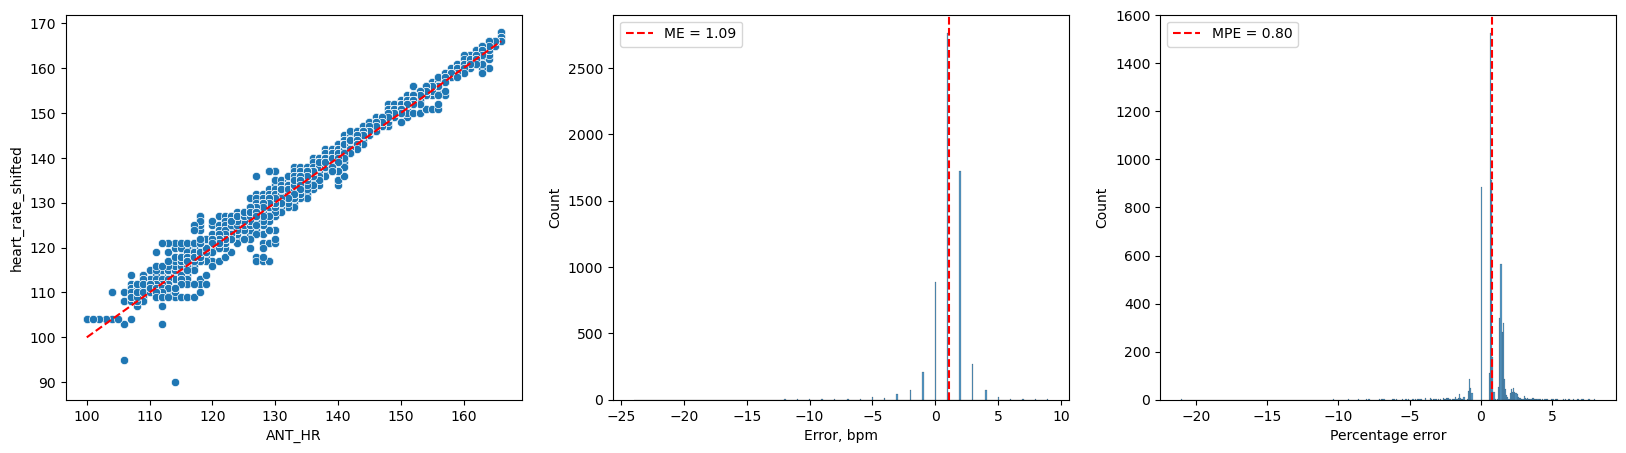

In [169]:
plot_distribution(data_shifted['ANT_HR'], data_shifted['heart_rate_shifted'], data_shifted['diff_shifted'])

## Final stats

### Original data

In [170]:
error_stats(data['ANT_HR'], data['heart_rate'], data['diff'])

Duration: 0 days 01:43:43
Mean ANT_HR: 137.31
Mean heart_rate: 138.36
MAPE = 1.39%
MAE = 1.86 bpm
RMSE = 2.60 bpm
Correlation = 0.981


### Delay-adjusted data

In [171]:
error_stats(data_shifted['ANT_HR'], data_shifted['heart_rate_shifted'], data_shifted['diff_shifted'])

Duration: 0 days 01:43:35
Mean ANT_HR: 137.35
Mean heart_rate_shifted: 138.43
MAPE = 1.03%
MAE = 1.38 bpm
RMSE = 1.78 bpm
Correlation = 0.993
